<a href="https://colab.research.google.com/github/phmcampos/Ecuador-JOKR/blob/main/Rapitienda_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
pip install statsmodels

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from datetime import datetime, time
import missingno as msno
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from scipy.stats import mannwhitneyu
from statsmodels.stats import multitest
from scipy.stats import shapiro
import math
import scipy.stats as stats

In [33]:
warnings.filterwarnings("ignore")

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
%cd /content/drive/MyDrive/Case Studies/Daki

/content/drive/MyDrive/Case Studies/Daki


In [36]:
!ls

holidays_events.csv  sample_submission.csv  submission.csv  train.csv
oil.csv		     stores.csv		    test.csv	    transactions.csv


In [37]:
def plot_data(df, x_label, y_label=None, figsize=(5, 5), n_indices=100, rotation=45, ticks=60, color='royalblue', rolling=5, main_observations=5, marker='o', scatter_label='Data Points', bins=10, edgecolor='black', mean=False, bar=False, distribution=False, time_series=False, groupby=False, smooth=False, dimension=False, main_select=False, scatter=False):

    """
    Args:
    - df (DataFrame): The DataFrame containing the data to be plotted.
    - x_label (str): The label for the x-axis.
    - y_label (str, optional): The label for the y-axis. Defaults to None.
    - figsize (tuple, optional): The size of the figure. Defaults to (5, 5).
    - n_indices (int, optional): Number of indices. Defaults to 100.
    - rotation (int, optional): Rotation angle for x-axis labels. Defaults to 45.
    - ticks (int, optional): Tick interval for x-axis. Defaults to 60.
    - color (str, optional): Color for the plot elements. Defaults to 'royalblue'.
    - rolling (int, optional): Rolling window size for smoothing. Defaults to 5.
    - main_observations (int, optional): Number of main observations. Defaults to 5.
    - marker (str, optional): Marker style for scatter plot. Defaults to 'o'.
    - scatter_label (str, optional): Label for scatter plot. Defaults to 'Data Points'.
    - bins (int, optional): Number of bins for histogram. Defaults to 10.
    - edgecolor (str, optional): Color of histogram edges. Defaults to 'black'.
    - mean (bool, optional): Whether to calculate mean. Defaults to False.
    - bar (bool, optional): Whether to plot bar chart. Defaults to False.
    - distribution (bool, optional): Whether to plot distribution. Defaults to False.
    - time_series (bool, optional): Whether to plot time series. Defaults to False.
    - groupby (bool, optional): Whether to group data. Defaults to False.
    - smooth (bool, optional): Whether to smooth data. Defaults to False.
    - dimension (bool, optional): Whether to consider dimension. Defaults to False.
    - main_select (bool, optional): Whether to select main. Defaults to False.
    - scatter (bool, optional): Whether to plot scatter plot. Defaults to False.
    """

    print('\n')
    df = df.copy()

    if groupby:
        if dimension:
            if main_select:
                df_main = df.groupby([dimension])[y_label].sum().reset_index().sort_values(by=[y_label], ascending=False)[dimension].head(main_observations)
                df = df[df[dimension].isin(df_main)][[x_label, dimension, y_label]].groupby([x_label, dimension]).sum().reset_index()
            else:
                df = df[[x_label, dimension, y_label]].groupby([x_label, dimension]).sum().reset_index()
        elif mean:
            df = df[[x_label, y_label]].groupby([x_label]).mean().reset_index()
        else:
            df = df[[x_label, y_label]].groupby([x_label]).sum().reset_index()

    if smooth:
        if dimension:
            df[y_label] = df.groupby(dimension)[y_label].rolling(rolling).mean().reset_index(0, drop=True)
        else:
            df[y_label] = df[y_label].rolling(rolling).mean().reset_index(0, drop=True)

    if scatter:
        x_values = df[x_label]
        y_values = df[y_label]

        plt.scatter(x_values, y_values, color=color, marker=marker, label=scatter_label)

        plt.title(f'{x_label} vs {y_label}')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.show()

    elif distribution:
        plt.figure(figsize=figsize)
        plt.hist(df[x_label], bins=bins, edgecolor=edgecolor)
        plt.title(f'{x_label} distribution')
        plt.xlabel(x_label)
        plt.ylabel('Frequency')
        plt.show()

    elif bar:
        plt.figure(figsize=figsize)
        df.set_index(x_label).plot(kind='bar', color=color)
        plt.title(f'{x_label} vs {y_label}')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(rotation=rotation)
        plt.show()

    elif time_series:
        matplotlib.rcParams.update({'figure.max_open_warning': 0})
        sns.set_style('whitegrid')
        colors = ["#004054", "#00C0D9"]
        matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
        sns.set(font="Verdana")
        sns.set(rc={'figure.figsize': (12, 5),
                    'axes.edgecolor': '#5B626C',
                    'text.color': '#5B626C',
                    'xtick.color': '#5B626C',
                    'ytick.color': '#5B626C',
                    'grid.color': '#e6e6e6',
                    'axes.facecolor': 'white'})

        plt.figure(figsize=(27, 7))

        if dimension:

            ax = sns.lineplot(
                data=df,
                x=x_label,
                y=y_label,
                hue=dimension,
                linewidth=3
            )

        else:

            ax = sns.lineplot(
                data=df,
                x=x_label,
                y=y_label,
                linewidth=3
            )

        plt.title(f'{y_label} over time')
        plt.xlabel(x_label, fontsize=15)
        plt.ylabel(y_label, fontsize=12)

        tick_positions = range(len(df[x_label].unique()))
        tick_labels = df[x_label].unique()
        plt.xticks(tick_positions, tick_labels)
        plt.xticks(rotation=rotation)

        current_ticks = plt.gca().get_xticks()

        new_ticks = current_ticks[::ticks]
        plt.xticks(new_ticks)
        plt.xlabel("")

        if dimension:
            plt.legend(loc='upper left')

    plt.show()

In [38]:
def coefficient_variation(df, intervals=3):
    """
    Calculate the coefficient of variation (CV) within pre-determined intervals.

    This function checks if it is possible to use LOCF or NOCF by analyzing
    the coefficient of variation for every given number of observations.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        intervals (int): The number of observations to consider in each interval.

    Returns:
        DataFrame: A DataFrame containing the calculated coefficients of variation.

    """
    total = 0
    list_cv = []

    while total <= len(df) - intervals:
        window_stats = df.iloc[total:total + intervals]['dcoilwtico'].describe()
        mean_value = window_stats['mean']
        std = window_stats['std']
        cv = std / mean_value
        list_cv.append(cv)
        total += intervals

    cv_df = pd.DataFrame(list_cv, columns=['cv'])

    return cv_df

In [39]:
def linear_regression(df, x_predictors, y_response):
    """
    Perform linear regression analysis.

    This function fits a linear regression model to the provided DataFrame `df`
    with predictors `x_predictors` and response variable `y_response`.

    Parameters:
        df (DataFrame): The DataFrame containing the predictors and response variable.
        x_predictors (list): A list of column names to be used as predictors in the regression model.
        y_response (str): The name of the column to be used as the response variable.

    Returns:
        tuple: A tuple containing the summary of the regression model, parameter estimates,
               and R-squared value.

    """
    y = df[y_response]
    x = df[x_predictors]

    # Add constant term
    x = sm.add_constant(x)

    # Fit OLS model
    model = sm.OLS(y, x).fit()

    # Get summary of the model
    summary = model.summary()

    # Get R-squared value
    rsquared = model.rsquared

    # Get parameter estimates and p-values
    params = pd.concat([model.params, model.pvalues], axis=1).round(2).reset_index()
    params.columns = ['variable', 'coefficient', 'p_value']

    print(summary)

    return summary, params, rsquared


In [40]:
df_holidays_events = pd.read_csv('holidays_events.csv')
df_oil = pd.read_csv('oil.csv')
df_sales = pd.read_csv('train.csv')
df_stores = pd.read_csv('stores.csv')

In [41]:
df_list = [df_holidays_events,df_oil,df_sales, df_stores]

In [42]:
data_dict = {
  'df_holidays_events': df_holidays_events,
  'df_oil': df_oil,
  'df_sales': df_sales,
  'df_stores' : df_stores
}

In [43]:
def get_dataframe_identifier(data_dict, target_df):
    """
    Retrieve the identifier of a DataFrame from a dictionary.

    This function searches a dictionary `data_dict` for a DataFrame `target_df`
    and returns its corresponding identifier.

    Parameters:
        data_dict (dict): A dictionary containing DataFrames with their identifiers as keys.
        target_df (DataFrame): The DataFrame whose identifier needs to be retrieved.

    Returns:
        str: The identifier of the DataFrame in the data_dict.

    Raises:
        Exception: If the DataFrame is not found in the data_dict.

    """
    for identifier, df in data_dict.items():
        if df is target_df:
            return identifier
    raise Exception('Sorry, the object was not found in the data_dict')

In [44]:
for data in df_list:
    identifier = get_dataframe_identifier(data_dict, data)
    print(f"{identifier}:")
    display(data.head(10))
    print(f"Shape: {data.shape}\n\nNull Percentages:\n{data.isnull().mean().sort_values(ascending=False)}\n\n")

df_holidays_events:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


Shape: (350, 6)

Null Percentages:
date           0.0
type           0.0
locale         0.0
locale_name    0.0
description    0.0
transferred    0.0
dtype: float64


df_oil:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


Shape: (1218, 2)

Null Percentages:
dcoilwtico    0.035304
date          0.000000
dtype: float64


df_sales:


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


Shape: (3000888, 6)

Null Percentages:
id             0.0
date           0.0
store_nbr      0.0
family         0.0
sales          0.0
onpromotion    0.0
dtype: float64


df_stores:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


Shape: (54, 5)

Null Percentages:
store_nbr    0.0
city         0.0
state        0.0
type         0.0
cluster      0.0
dtype: float64




In [45]:
for data in df_list:
    identifier = get_dataframe_identifier(data_dict, data)
    duplicates = data.duplicated().sum()
    print(f'{identifier} has {duplicates} duplicate rows.')

df_holidays_events has 0 duplicate rows.
df_oil has 0 duplicate rows.
df_sales has 0 duplicate rows.
df_stores has 0 duplicate rows.


In [46]:
for data in df_list:
    identifier = get_dataframe_identifier(data_dict, data)
    print(f'{identifier}')
    print(f'{data.dtypes}\n')

df_holidays_events
date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

df_oil
date           object
dcoilwtico    float64
dtype: object

df_sales
id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

df_stores
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object



In [47]:
for data in df_list[:3]:
    """
    Iterate over the first three dataframes in the list to understand date limits.

    Parameters:
        df_list (list): A list containing dataframe objects.

    Returns:
        None
    """
    min_date = data['date'].min()
    max_date = data['date'].max()
    print(f"{get_dataframe_identifier(data_dict, data)} min date is {min_date}, and max {max_date}.")

df_holidays_events min date is 2012-03-02, and max 2017-12-26.
df_oil min date is 2013-01-01, and max 2017-08-31.
df_sales min date is 2013-01-01, and max 2017-08-15.


In [48]:
# Select only equivalent time series (from 2013-01-01 to 2017-08-15)
date_min = df_sales['date'].min()
date_max = df_sales['date'].max()

# Filter df_holidays_events and df_oil based on the date range of df_sales
df_holidays_events = df_holidays_events[(df_holidays_events['date'] >= date_min) &
                                        (df_holidays_events['date'] <= date_max)].reset_index(drop=True)
df_oil = df_oil[(df_oil['date'] >= date_min) & (df_oil['date'] <= date_max)].reset_index(drop=True)

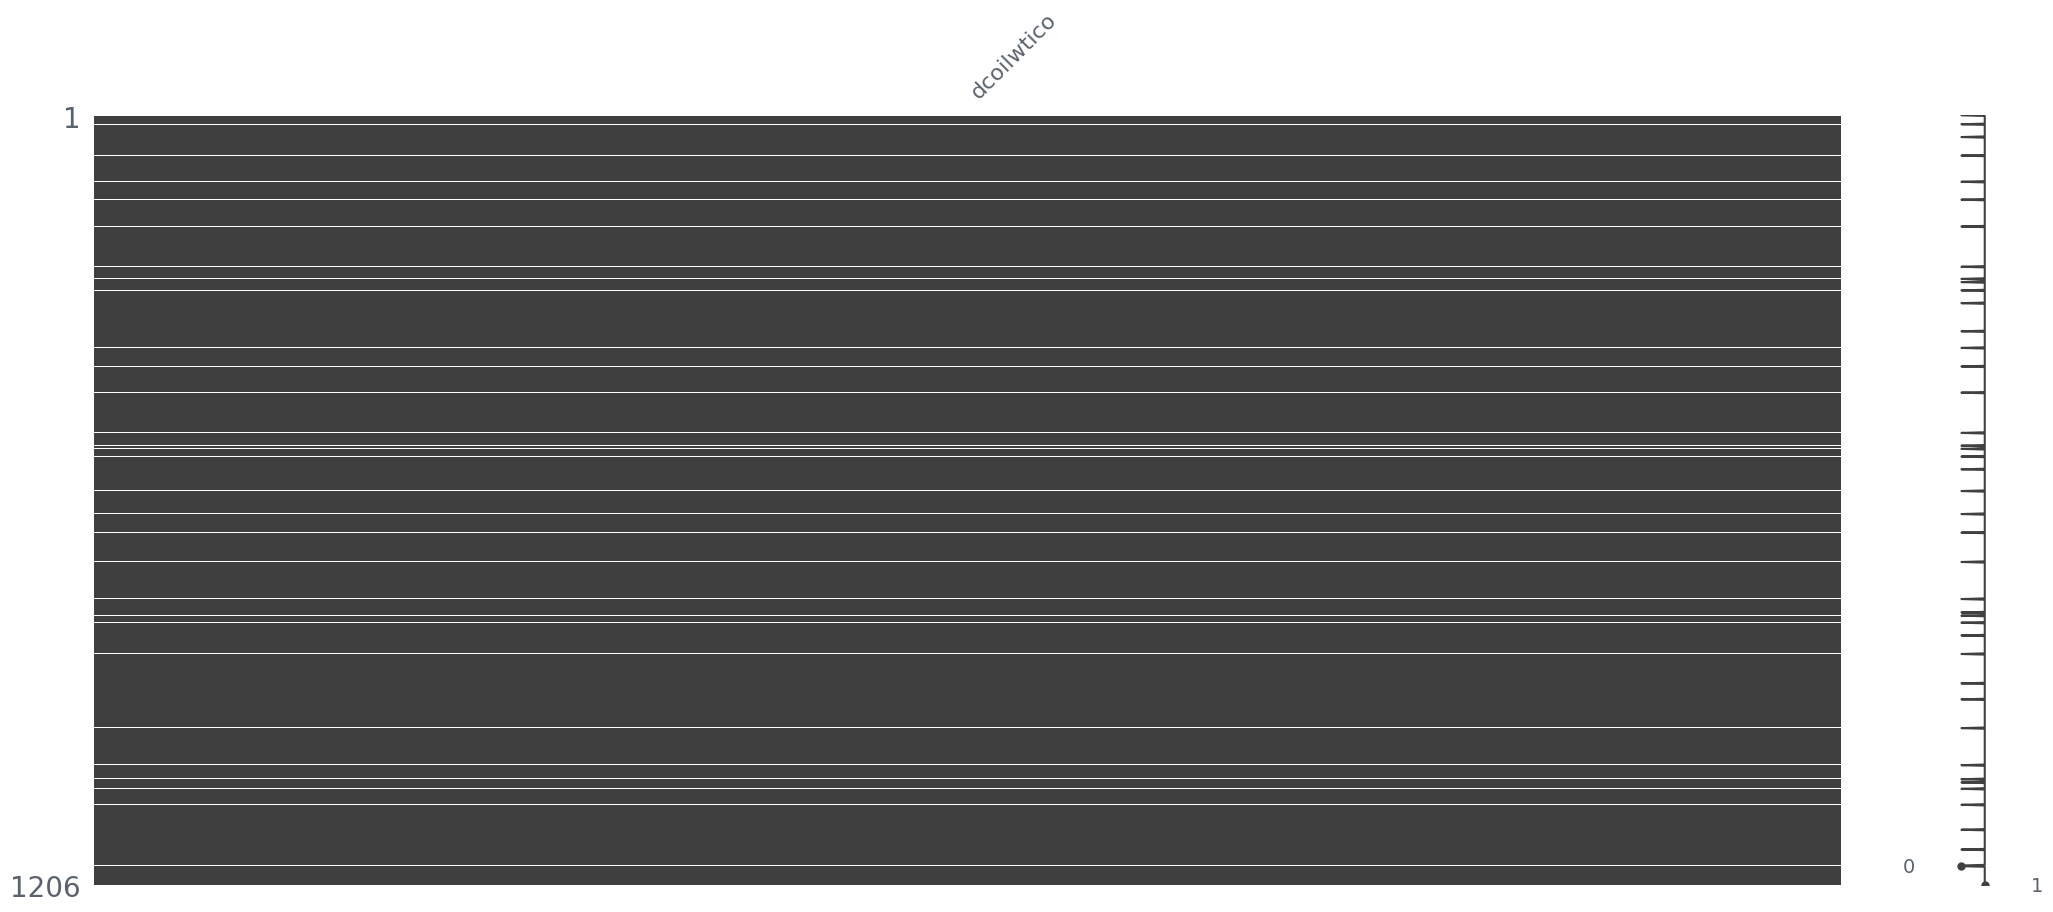

<Figure size 500x500 with 0 Axes>

In [49]:
# Plotting the missingno matrix
msno.matrix(df_oil[['dcoilwtico']])
plt.figure(figsize=(5, 5))
plt.show()

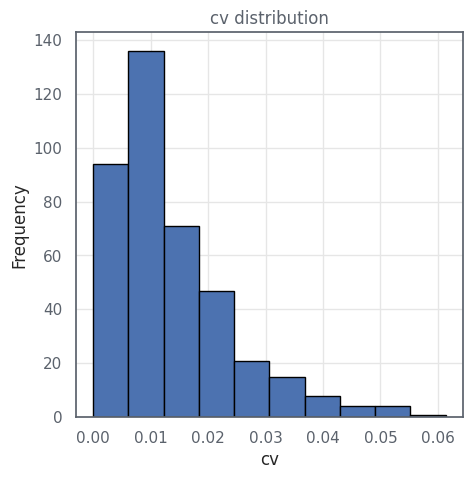

In [50]:
# Plot coefficient of variation distribution
cv_values = coefficient_variation(df=df_oil)
plot_data(cv_values, x_label='cv', distribution=True)

In [51]:
# Apply Next Observation Carried Backward (NOCB) method to fill missing values in 'dcoilwtico' column
df_oil['dcoilwtico'].fillna(method='bfill', inplace=True)

In [52]:
# Q1

In [53]:
def q1(df_sales):
    """
    Perform analysis and visualization for Q1.

    Args:
        df_sales (DataFrame): DataFrame containing sales data.

    Returns:
        None
    """
    # Group by date and sum sales, then plot distribution of 'onpromotion' and 'sales'
    df = df_sales[['date', 'onpromotion', 'sales']].groupby(['date']).sum().reset_index()
    plot_data(df=df, x_label='onpromotion', distribution=True)
    plot_data(df=df, x_label='sales', distribution=True)
    plot_data(df=df, x_label='date', y_label='onpromotion', time_series=True, smooth=False)

    # Plot distribution of 'onpromotion' after last occurrence of 0
    df = df.iloc[df.index[df['onpromotion'] == 0].get_level_values(0)[-1] + 1:]
    plot_data(df=df, x_label='onpromotion', distribution=True)

    # Plot scatter plot of 'onpromotion' vs. 'sales' and perform linear regression
    plot_data(df=df, x_label='onpromotion', y_label='sales', scatter=True)
    summary, params, rsquared = linear_regression(df, 'onpromotion', 'sales')

    # Plot distribution and scatter plot after applying log transformation to 'onpromotion' and perform linear regression
    df['onpromotion_log'] = np.log1p(df['onpromotion'])
    plot_data(df=df, x_label='onpromotion_log', distribution=True)
    plot_data(df=df, x_label='onpromotion_log', y_label='sales', scatter=True)
    summary, params, rsquared = linear_regression(df, 'onpromotion_log', 'sales')

    return None

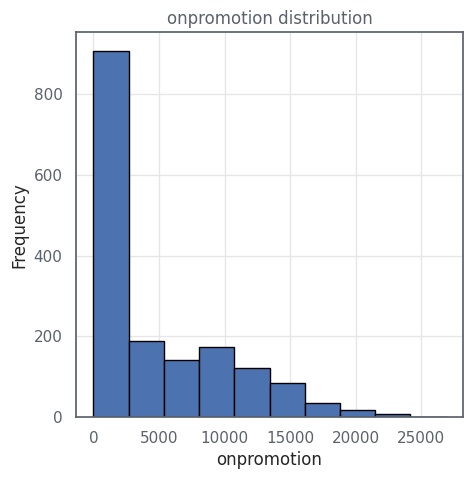

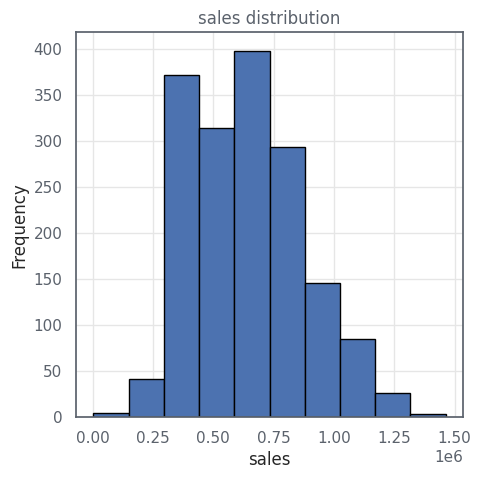

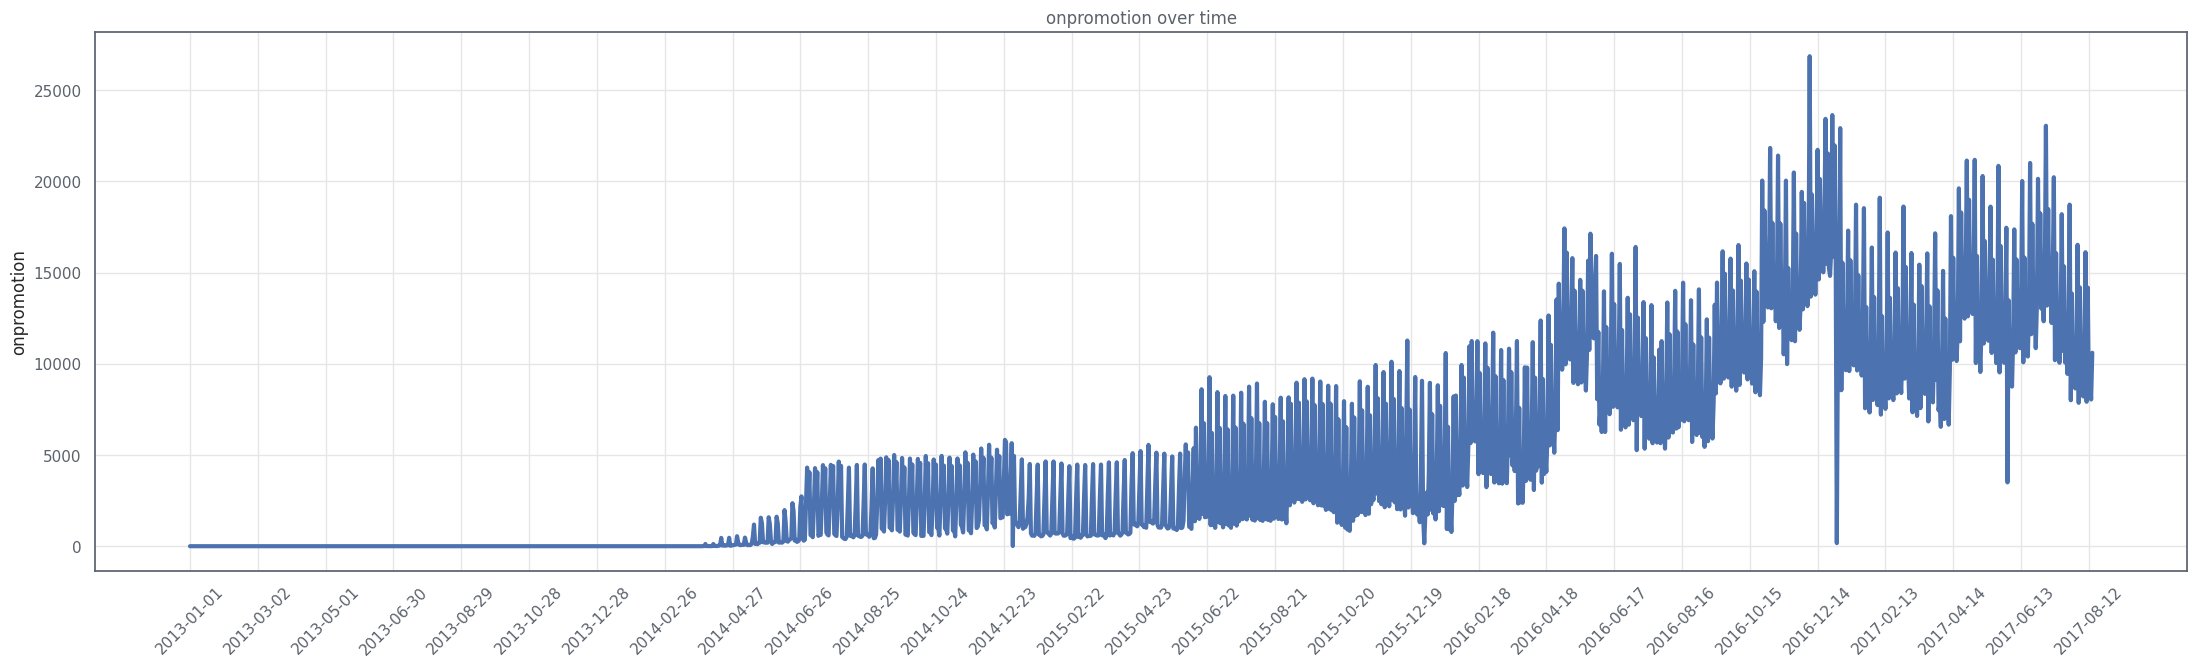

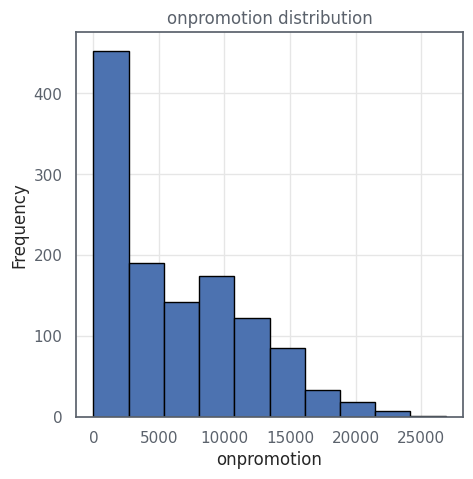

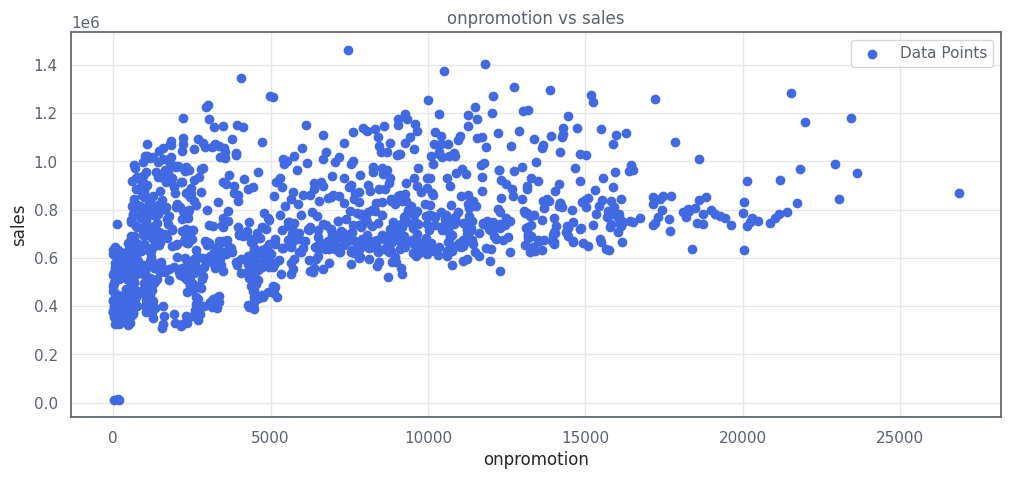

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     281.2
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           5.50e-57
Time:                        22:58:07   Log-Likelihood:                -16702.
No. Observations:                1230   AIC:                         3.341e+04
Df Residuals:                    1228   BIC:                         3.342e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.098e+05   8401.679     72.579      

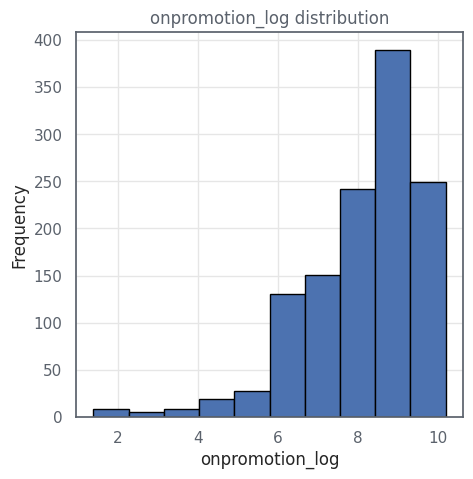

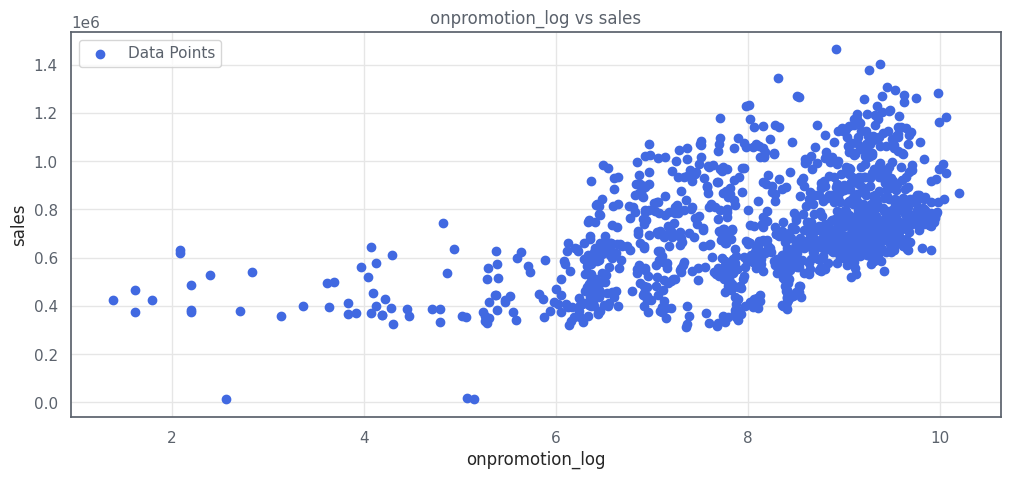

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     386.5
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           4.95e-75
Time:                        22:58:08   Log-Likelihood:                -16661.
No. Observations:                1230   AIC:                         3.333e+04
Df Residuals:                    1228   BIC:                         3.334e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.313e+05   3.03e+04     

In [54]:
q1(df_sales)

In [55]:
# Q2

In [56]:
def q2(df_sales, df_stores, df_holidays_events):
    """
    Perform analysis and exploration of sales data, including trend analysis and statistical tests.

    Parameters:
    df_sales (DataFrame): DataFrame containing sales data.
    df_stores (DataFrame): DataFrame containing store data.
    df_holidays_events (DataFrame): DataFrame containing holiday events data.

    Returns:
    Tuple: A tuple containing:
        - DataFrame: Main holiday events DataFrame.
        - list: List of main localities.
        - DataFrame: Detrended sales DataFrame.
    """
    # Copy the sales DataFrame for analysis
    df = df_sales.copy()

    # Plot sales data over time
    plot_data(df=df, x_label='date', y_label='sales', time_series=True, groupby=True, smooth=True)

    # Plot sales data over time with family dimension
    plot_data(df=df_sales, x_label='date', y_label='sales', dimension='family', time_series=True,
              groupby=True, smooth=True, main_select=True, main_observations=5, rolling=15)

    # Filter sales data for 'GROCERY I' family
    df = df_sales[df_sales['family'] == 'GROCERY I']
    df = df[['date', 'sales']].groupby(['date']).sum().reset_index()

    # Convert date to datetime and set as index
    df['datetime'] = pd.to_datetime(df['date'])
    df.set_index('datetime', inplace=True)

    # Apply Seasonal-Trend decomposition
    stl = STL(df['sales'], seasonal=7, period=365)
    res = stl.fit()
    trend_data = res.trend

    # Plot detrended sales data over time
    plot_data(df=df, x_label='date', y_label='sales', time_series=True, smooth=False)
    df['sales'] = df['sales'] / trend_data
    df_detrended = df.copy()
    plot_data(df=df, x_label='date', y_label='sales', time_series=True, smooth=False)

    # Extract year, month, day, and weekday information
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['day'] = pd.to_datetime(df['date']).dt.day
    df['weekday'] = pd.to_datetime(df['date']).dt.dayofweek

    # Plot sales data grouped by month, day, and weekday
    for feature in ['month', 'day', 'weekday']:
        plot_data(df=df, x_label=feature, y_label='sales', groupby=True, mean=True, bar=True)

    # Initialize an empty list to store styled DataFrames for Shapiro-Wilk test results
    styled_dfs = []

    # Loop through each feature (month, day, weekday) for Shapiro-Wilk test
    for feature in ['month', 'day', 'weekday']:
        df_sample = df[[feature, 'sales']]

        # Initialize an empty DataFrame for Shapiro-Wilk test results
        results_df = pd.DataFrame(columns=['feature', 'period', 'statistic', 'pvalue', 'significant'])
        alpha = 0.05

        # Loop through each period in the feature
        for period in df_sample[feature].unique():
            period_data = df_sample[df_sample[feature] == period]['sales'].values

            # Perform Shapiro-Wilk test
            stat, p_value = shapiro(period_data)

            # Store test results in the DataFrame
            results_df = results_df.append({
                'feature': feature,
                'period': period,
                'statistic': stat,
                'pvalue': p_value,
                'significant': p_value > alpha
            }, ignore_index=True)

        # Sort the results DataFrame
        results_df = results_df.sort_values(['significant', 'pvalue'], ascending=[False, False]).reset_index(drop=True)

        # Display the styled bar chart for the feature and add to the list
        styled_df = results_df.style.bar(
            subset=['statistic'],
            align='mean',
            color=['#d65f5f', '#5fba7d']
        )
        styled_dfs.append((feature, styled_df))

    # Display Shapiro-Wilk test results
    for feature, styled_df in styled_dfs:
        print(f"\n\nShapiro Test results for {feature}:")
        display(styled_df)

    # Initialize an empty list to store styled DataFrames for Mann-Whitney U-test results
    styled_dfs = []

    # Loop through each feature (month, day, weekday) for Mann-Whitney U-test
    for feature in ['month', 'day', 'weekday']:
        results_df = pd.DataFrame(columns=['feature', 'period', 'U_statistic', 'pvalue', 'significant', 'adjust_pvalue'])

        # Loop through each period in the feature
        for period in df[[feature, 'sales']][feature].unique():
            period_data = df[df[feature] == period]['sales'].values
            others_data = df[df[feature] != period]['sales'].values

            # Perform Mann-Whitney U-test
            stat, p_value = mannwhitneyu(period_data, others_data)

            # Store test results in the DataFrame
            results_df = results_df.append({'feature': feature, 'period': period, 'U_statistic': stat, 'pvalue': p_value},
                                           ignore_index=True)

        # Apply Bonferroni correction
        multitest_result = multitest.multipletests(results_df['pvalue'], method="bonferroni")
        results_df['significant'] = multitest_result[0]
        results_df['adjust_pvalue'] = multitest_result[1]

        # Sort the results DataFrame
        results_df = results_df.sort_values(['significant', 'adjust_pvalue'], ascending=[False, True]).reset_index(drop=True)

        # Display the styled bar chart and add to the list
        styled_df = results_df.style.bar(
            subset=['U_statistic'],
            align='mean',
            color=['#d65f5f', '#5fba7d']
        )
        styled_dfs.append((feature, styled_df))

    # Display Mann-Whitney U-test results
    for feature, styled_df in styled_dfs:
        print(f"\n\nU-test Results for {feature}:")
        display(styled_df)

    def holidays_exploration(df_sales, df_stores, df_holidays_events):
        """
        Explore holiday events based on sales, store, and holiday events data.

        Parameters:
        df_sales (DataFrame): DataFrame containing sales data.
        df_stores (DataFrame): DataFrame containing store data.
        df_holidays_events (DataFrame): DataFrame containing holiday events data.

        Returns:
        Tuple: A tuple containing:
            - DataFrame: DataFrame containing main holiday events.
            - list: List of main localities.
        """
        # Merge sales and stores DataFrames to get city-wise sales
        df = df_sales.merge(df_stores, how='left', on='store_nbr')
        df = df[['city', 'sales']].groupby(['city']).sum().reset_index().merge(df_stores[['city', 'state']], how='left', on='city').drop_duplicates()

        # Calculate percentage of sales for each city
        df['percentage'] = (df['sales'] / df['sales'].sum()).round(2)

        # Determine if the city is significant based on sales percentage
        df['amenity'] = [True if x <= 0.05 else False for x in df['percentage']]

        # Initialize list of main localities with default value
        main_locals = ['Ecuador']

        # Append significant cities and states to main locals list
        for local in ['city', 'state']:
            main_locals.extend(df[df['amenity'] == False][local])

        # Copy holiday events DataFrame for exploration
        df = df_holidays_events.copy()

        # Extract year, month, and day from date column
        df['year'] = pd.to_datetime(df['date']).dt.year
        df['month'] = pd.to_datetime(df['date']).dt.month
        df['day'] = pd.to_datetime(df['date']).dt.day

        # Filter main holiday events based on significant localities and date range
        df_main_holidays = df[df['locale_name'].isin(main_locals)].groupby('date').first().reset_index()
        df_main_holidays = df_main_holidays[df_main_holidays['date'] >= '2013-08-15']
        df = df_main_holidays.copy()

        def proportions(df):
            """
            Analyze holiday proportions by month and overall unique descriptions.

            Parameters:
            df (DataFrame): DataFrame containing holiday events data.

            Returns:
            None
            """
            # Extract month-wise holiday counts and proportions
            holidays_month = df[['month', 'day', 'description']].drop_duplicates()
            df = df[['month', 'date']].groupby(['month']).count().reset_index().sort_values(by='date', ascending=False)
            df['percentage'] = (df['date'] / df['date'].sum()).round(2)
            print(f'\n\nResults for holiday shares by month:\n{df}')

            # Analyze unique holiday descriptions for specific months
            for month in [12, 5, 4]:
                month_holidays = holidays_month[holidays_month['month'] == month]
                unique_descriptions = month_holidays['description'].unique()
                print(f"\n\nResults for month {month}:\n{unique_descriptions}")

            # Display unique holiday descriptions for all months
            unique_descriptions = holidays_month['description'].unique()
            print(f'\n\nUnique holiday descriptions:\n{unique_descriptions}')

            return None

        # Perform holiday proportions analysis
        proportions(df)

        # Filter out specific holiday events
        df = df_main_holidays[~(df_main_holidays['description'].str.contains(r'Terremoto Manabi|Mundial de futbol Brasil', case=False, regex=True))]

        # Perform holiday proportions analysis on filtered events
        proportions(df)

        # Return main holiday events and main localities list
        return df_main_holidays, main_locals


    df_main_holidays, main_locals = holidays_exploration(df_sales, df_stores, df_holidays_events)

    return df_main_holidays, main_locals, df_detrended

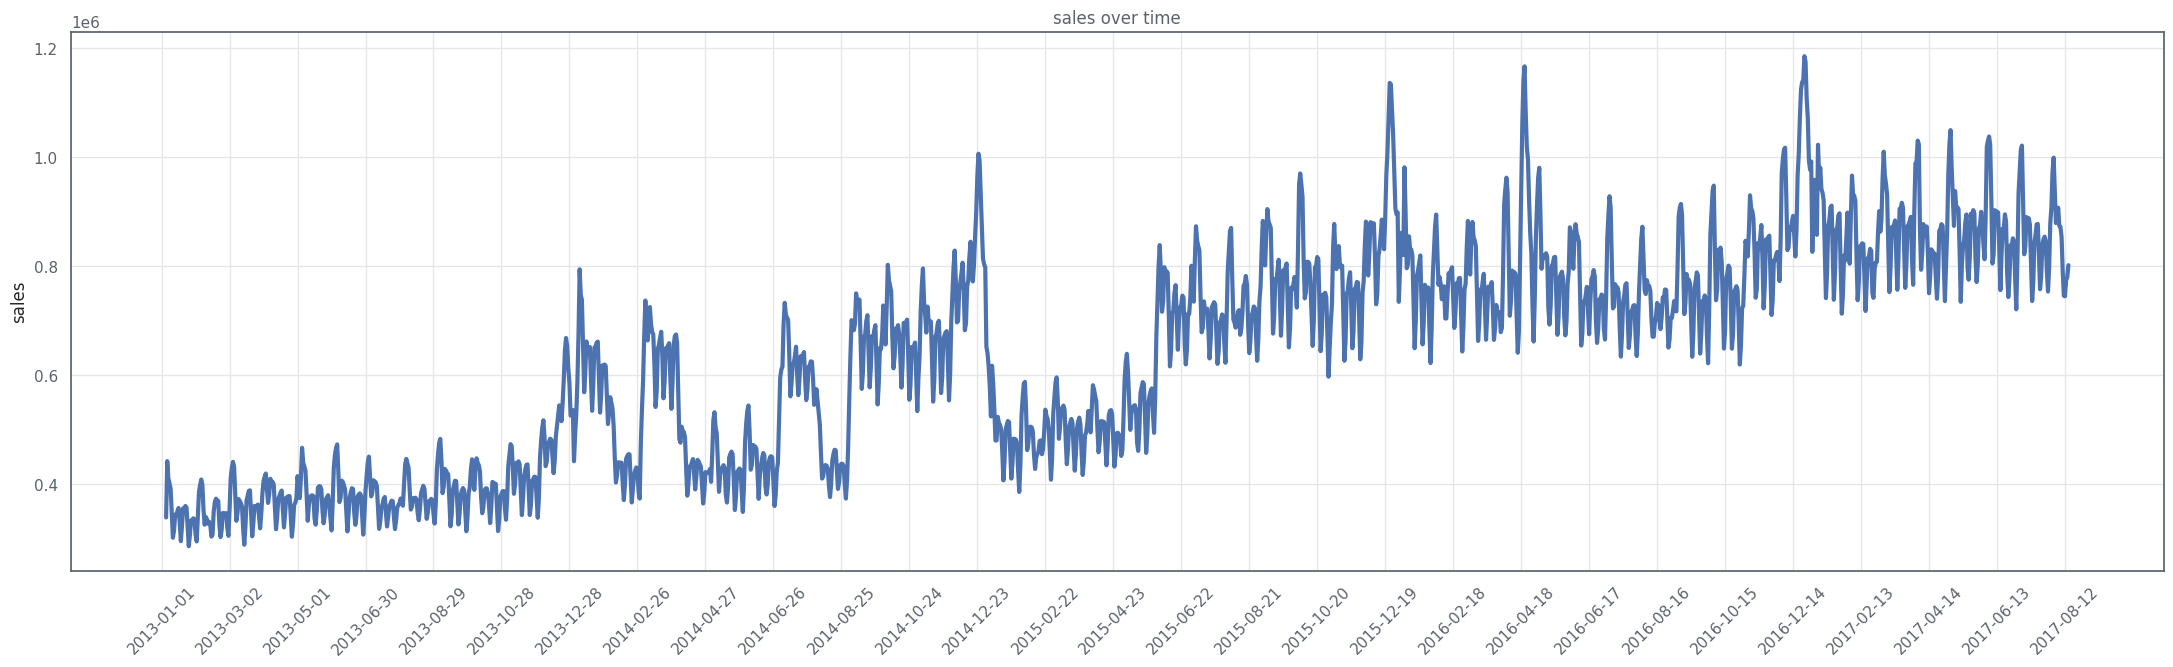

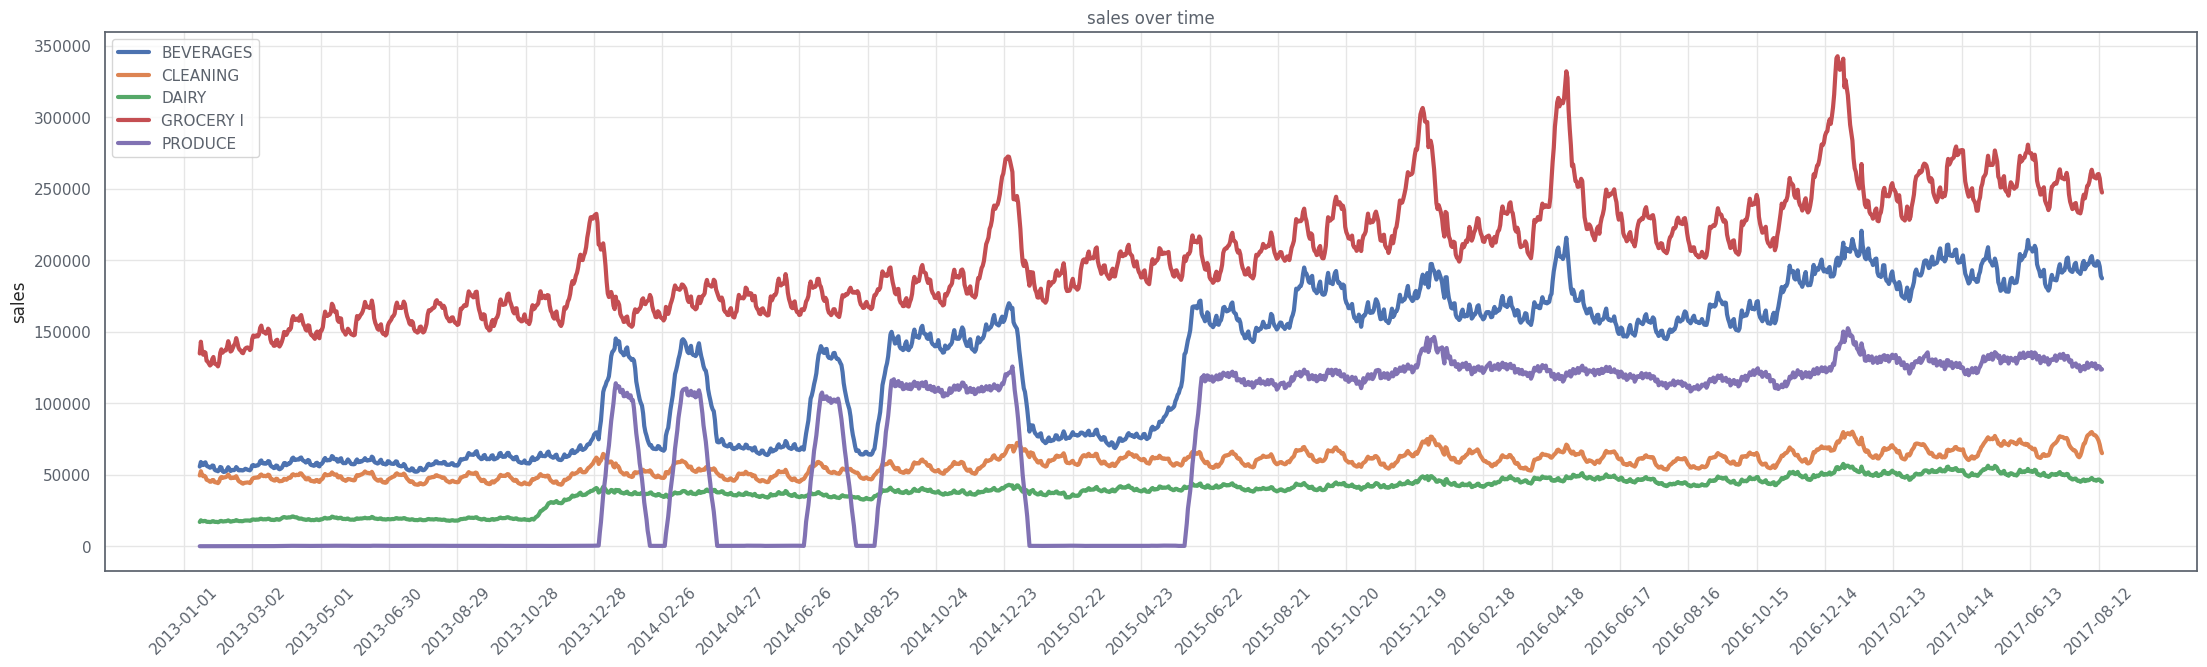

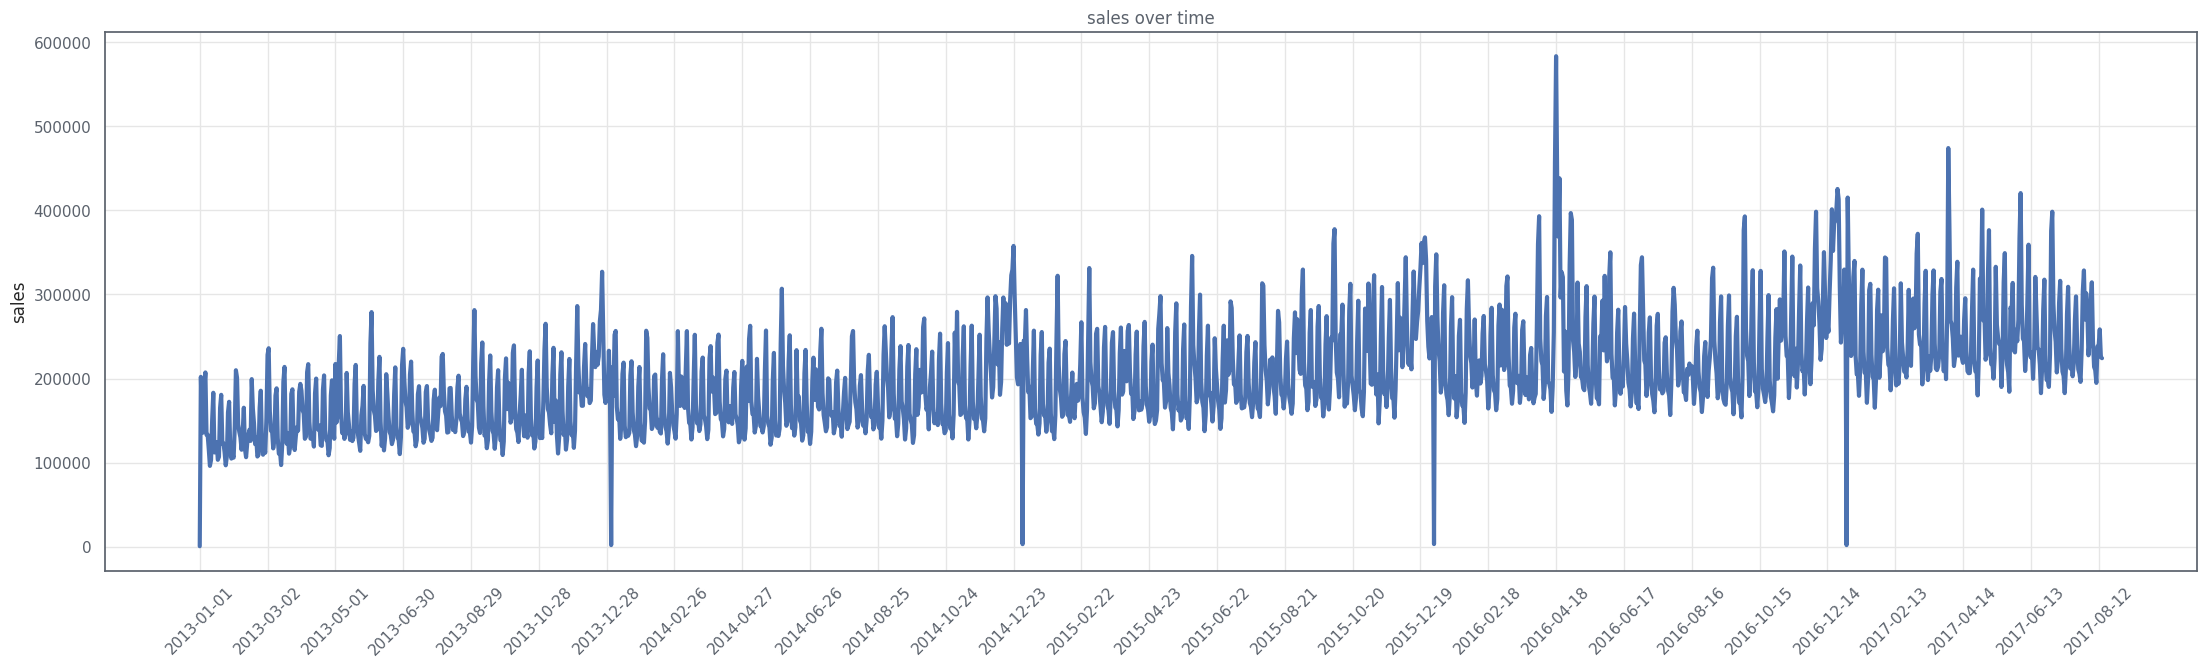

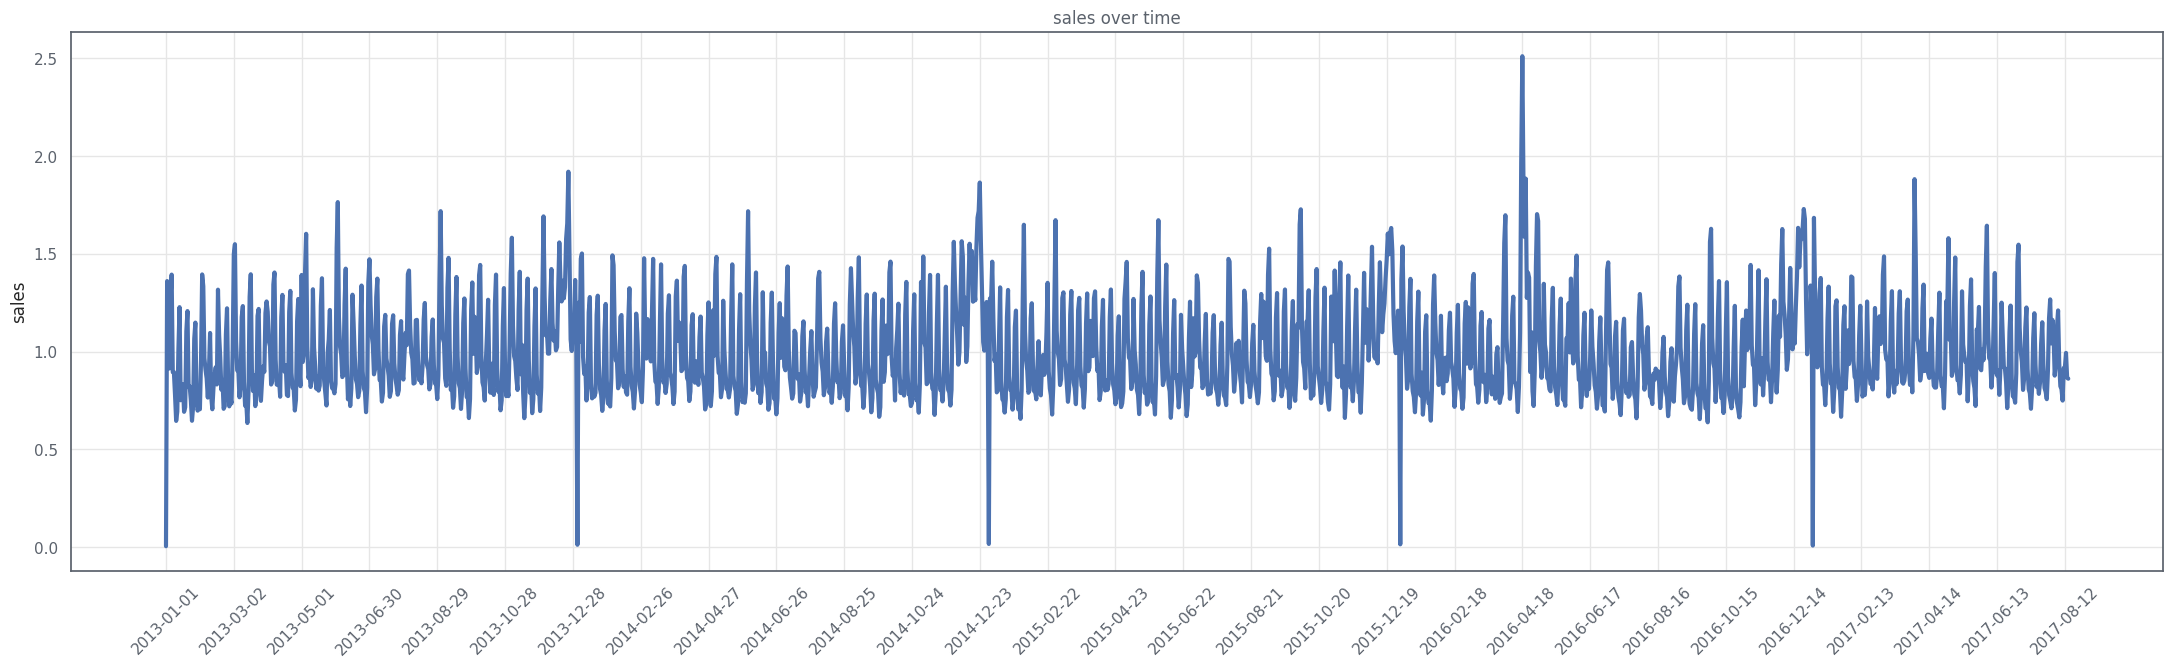

<Figure size 500x500 with 0 Axes>

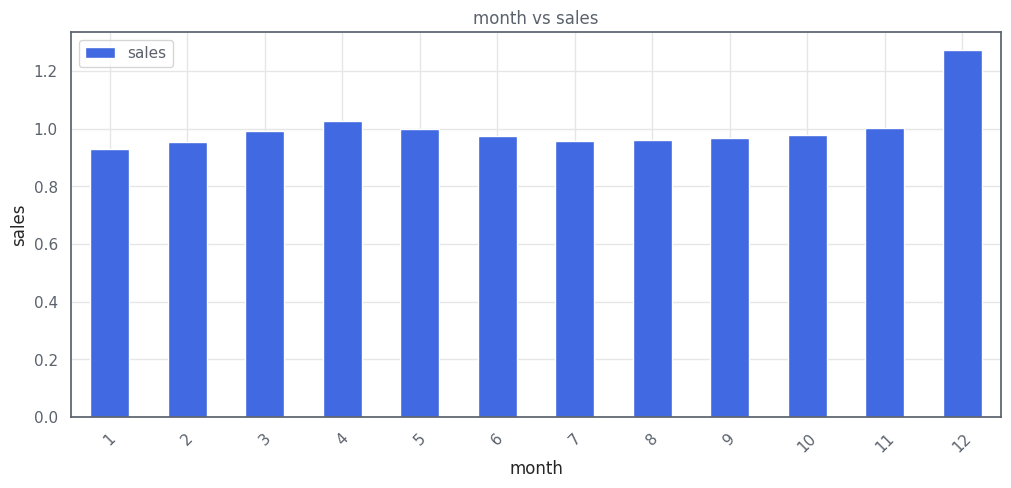

<Figure size 500x500 with 0 Axes>

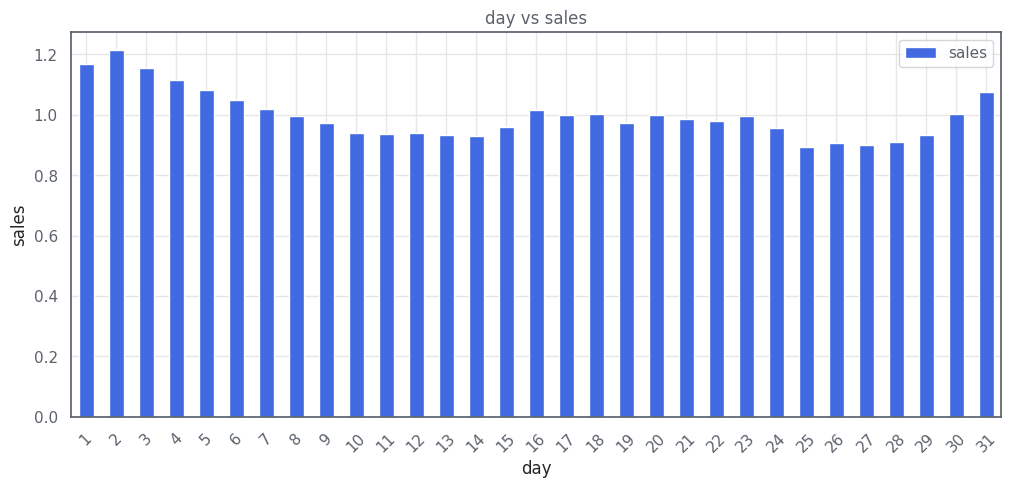

<Figure size 500x500 with 0 Axes>

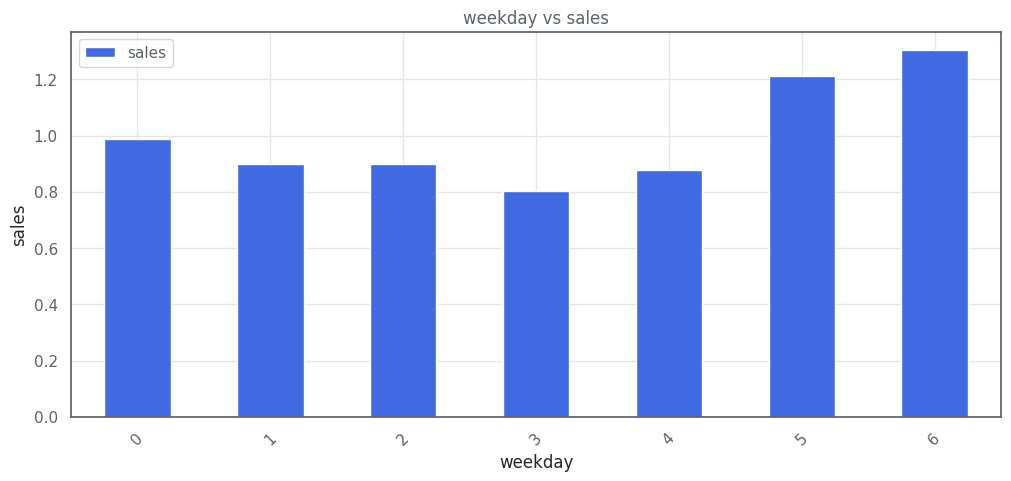



Shapiro Test results for month:


,feature,period,statistic,pvalue,significant
0,month,12,0.951721,0.000290,False
1,month,11,0.922623,0.000003,False
2,month,9,0.916308,0.000001,False
3,month,8,0.922285,0.000001,False
4,month,7,0.920375,0.000000,False
5,month,3,0.914879,0.000000,False
6,month,10,0.893443,0.000000,False
7,month,2,0.904862,0.000000,False
8,month,1,0.910494,0.000000,False
9,month,6,0.903845,0.000000,False




Shapiro Test results for day:


,feature,period,statistic,pvalue,significant
0,day,31,0.950457,0.148496,True
1,day,10,0.915534,0.000806,False
2,day,12,0.910958,0.000543,False
3,day,30,0.894247,0.000312,False
4,day,2,0.904259,0.000310,False
5,day,16,0.901774,0.000287,False
6,day,4,0.901013,0.000238,False
7,day,27,0.898773,0.000226,False
8,day,5,0.899446,0.000209,False
9,day,14,0.898077,0.000187,False




Shapiro Test results for weekday:


,feature,period,statistic,pvalue,significant
0,weekday,5,0.943471,0.000000,False
1,weekday,6,0.938796,0.000000,False
2,weekday,2,0.815242,0.000000,False
3,weekday,4,0.798502,0.000000,False
4,weekday,1,0.772838,0.000000,False
5,weekday,3,0.743239,0.000000,False
6,weekday,0,0.707098,0.000000,False




U-test Results for month:


,feature,period,U_statistic,pvalue,significant,adjust_pvalue
0,month,12,154704.000000,0.000000,True,0.000000
1,month,1,97996.000000,0.000380,True,0.004556
2,month,9,84941.000000,0.083025,False,0.996298
3,month,2,99610.000000,0.097063,False,1.000000
4,month,3,119813.000000,0.819682,False,1.000000
5,month,4,119375.000000,0.446779,False,1.000000
6,month,5,118684.000000,0.974278,False,1.000000
7,month,6,107828.000000,0.203922,False,1.000000
8,month,7,109364.000000,0.113377,False,1.000000
9,month,8,101690.000000,0.300377,False,1.000000




U-test Results for day:


,feature,period,U_statistic,pvalue,significant,adjust_pvalue
0,day,2,70387.000000,0.000000,True,0.000000
1,day,1,67764.000000,0.000000,True,0.000000
2,day,3,65370.000000,0.000000,True,0.000001
3,day,4,60860.000000,0.000020,True,0.000608
4,day,25,29496.000000,0.000383,True,0.011875
5,day,5,58272.000000,0.000391,True,0.012122
6,day,27,32830.000000,0.000741,True,0.022973
7,day,26,32843.000000,0.000751,True,0.023281
8,day,28,33775.000000,0.001887,False,0.058493
9,day,6,54439.000000,0.013332,False,0.413307




U-test Results for weekday:


,feature,period,U_statistic,pvalue,significant,adjust_pvalue
0,weekday,6,310673.000000,0.000000,True,0.000000
1,weekday,3,57325.000000,0.000000,True,0.000000
2,weekday,5,288348.000000,0.000000,True,0.000000
3,weekday,4,116211.000000,0.000000,True,0.000000
4,weekday,1,126715.000000,0.000000,True,0.000000
5,weekday,2,128681.000000,0.000000,True,0.000000
6,weekday,0,187412.000000,0.052845,False,0.369916




Results for holiday shares by month:
    month  date  percentage
10     12    38        0.25
4       5    31        0.20
3       4    18        0.12
9      11    15        0.10
6       7    15        0.10
0       1     7        0.05
5       6     7        0.05
8      10     6        0.04
1       2     6        0.04
7       8     6        0.04
2       3     3        0.02


Results for month 12:
['Fundacion de Quito-1' 'Fundacion de Quito' 'Navidad-4' 'Navidad-3'
 'Navidad-2' 'Navidad-1' 'Navidad' 'Navidad+1' 'Primer dia del ano-1'
 'Cyber Monday' 'Recupero Puente Navidad' 'Puente Navidad']


Results for month 5:
['Dia del Trabajo' 'Dia de la Madre-1' 'Dia de la Madre'
 'Batalla de Pichincha' 'Terremoto Manabi+16' 'Terremoto Manabi+17'
 'Terremoto Manabi+18' 'Terremoto Manabi+19' 'Terremoto Manabi+20'
 'Terremoto Manabi+22' 'Terremoto Manabi+23' 'Terremoto Manabi+24'
 'Terremoto Manabi+25' 'Terremoto Manabi+26' 'Terremoto Manabi+27'
 'Terremoto Manabi+28' 'Terremoto Manabi+29' 'Terremo

In [57]:
df_main_holidays, main_locals, df_detrended = q2(df_sales, df_stores, df_holidays_events)

In [58]:
# Q3

In [59]:
def q3(df_sales, df_oil, df_main_holidays):
    """
    Analyze sales data with oil prices, holiday indicators, and supply issues.

    Parameters:
    df_sales (DataFrame): DataFrame containing sales data.
    df_oil (DataFrame): DataFrame containing oil prices data.
    df_main_holidays (DataFrame): DataFrame containing main holiday events data.

    Returns:
    Tuple: A tuple containing:
        - DataFrame: Summary statistics of linear regression.
        - DataFrame: Parameters and coefficients of linear regression.
        - float: R-squared value of the linear regression model.
    """
    # Prepare sales data
    df = df_sales[['date', 'onpromotion', 'sales']].groupby(['date']).sum().reset_index()
    df['onpromotion_log'] = np.log1p(df['onpromotion'])
    df = df.merge(df_oil, how='left', on='date').fillna(method='ffill')
    df['dcoilwtico_log'] = np.log1p(df['dcoilwtico'])
    df = df.iloc[df.index[df['onpromotion']==0].get_level_values(0)[-1] + 1:]

    # Plot distribution of oil prices
    plot_data(df, x_label='dcoilwtico', distribution=True)
    plot_data(df, x_label='dcoilwtico_log', distribution=True)

    # Create temporal features
    df['january'] = pd.to_datetime(df['date']).dt.month.apply(lambda x: 1 if x == 1 else 0)
    df['december'] = pd.to_datetime(df['date']).dt.month.apply(lambda x: 1 if x == 12 else 0)
    df['payday_period'] = pd.to_datetime(df['date']).dt.day.apply(lambda x: 1 if x in (1, 2, 3, 4, 5) else 0)
    df['pre_payday_period'] = pd.to_datetime(df['date']).dt.day.apply(lambda x: 1 if x in (25, 26, 27) else 0)
    df['weekday'] = pd.to_datetime(df['date']).dt.dayofweek.astype('object')

    # Identify extreme holiday events
    extreme_holidays = df_main_holidays[
        (df_main_holidays['description'].str.contains(r'Terremoto Manabi|Mundial de futbol Brasil', case=False, regex=True))
    ]['date'].tolist()

    holiday_dates = set(df_main_holidays['date'])
    df['holiday'] = [1 if (x in holiday_dates) and (x not in extreme_holidays) else 0 for x in df['date']]

    # Encode categorical features
    df = pd.concat([df.drop(['weekday'], axis=1), pd.get_dummies(df['weekday'], prefix='day', prefix_sep='_', drop_first=True)], axis=1)

    def supply_feature(df, df_sales):
        """
        Analyze supply issues based on sales of PRODUCE family.

        Parameters:
        df (DataFrame): DataFrame containing sales data with temporal features.
        df_sales (DataFrame): DataFrame containing sales data.

        Returns:
        DataFrame: DataFrame with supply issues indicator added.
        """
        print('\n\n')
        df_regression = df.copy()

        filter_limits = []
        max_values = []

        df = df_sales[['date', 'family', 'sales']].groupby(['date', 'family']).sum().reset_index()
        df = df[df['family'] == 'PRODUCE'].drop(['family'], axis=1)

        for n in [200 + i * 200 for i in range(30)]:
            filter_limits.append(n)
            max_values.append(df[(df['sales']<n)].describe().loc['max'][0])

        plt.plot(filter_limits, max_values, marker='o', linestyle='-')
        plt.xlabel('filter_limits')
        plt.ylabel('max_values')
        plt.title('filter_limits vs max_values')
        plt.show()

        df = df[df['sales']<3000]
        df.columns = ['date', 'sales_produce']

        df = df_regression.merge(df, how='left', on ='date')
        df_regression['suply_issues'] = [1 if not math.isnan(x) else 0 for x in df['sales_produce']]
        df = df_regression.copy()

        return df

    # Analyze supply issues
    df = supply_feature(df, df_sales)

    # Define predictors and response variable
    x_predictors = ['onpromotion_log', 'dcoilwtico_log', 'january', 'december', 'holiday', 'pre_payday_period', 'payday_period', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'suply_issues']
    y_response = 'sales'

    # Display proportions of predictor variables
    print(f'\n\nPredictor variables proportions:\n{df[x_predictors[2:]].mean()}')

    # Perform linear regression
    summary, params, rsquared = linear_regression(df, x_predictors, y_response)

    # Add 'significant' column based on p-value threshold
    params['significant'] = np.where(params['p_value'] < 0.05, True, False)

    # Sort the DataFrame
    params = params.sort_values(['significant', 'coefficient'], ascending=[False, False]).reset_index(drop=True)

    # Display the styled table
    styled_df = params.style.bar(
        subset=['coefficient'],
        align='mean',
        color=['#d65f5f', '#5fba7d']
    )
    print('\n\nCoefficient Table:')
    display(styled_df)

    def extreme_events():
        """
        Analyze extreme holiday events using statistical tests.
        """
        def weekday_of_month(date):
            day_of_month = date.day
            weekday = date.weekday()
            week_number = (day_of_month - 1) // 7 + 1
            return f'Week {week_number} - {date.strftime("%A")} of {date.strftime("%B")}'

        # Filter sales data
        df = df_sales
        df = df[['date', 'sales']].groupby(['date']).sum().reset_index()

        # Convert date to datetime and set as index
        df['datetime'] = pd.to_datetime(df['date'])
        df.set_index('datetime', inplace=True)

        # Apply Seasonal-Trend decomposition
        stl = STL(df['sales'], seasonal=7, period=365)
        res = stl.fit()
        trend_data = res.trend

        # Plot detrended sales data over time
        plot_data(df=df, x_label='date', y_label='sales', time_series=True, smooth=False)
        df['sales'] = df['sales'] / trend_data
        plot_data(df=df, x_label='date', y_label='sales', time_series=True, smooth=False)

        df = df.reset_index()
        df['weekday_of_month'] = df['datetime'].apply(weekday_of_month)

        styled_dfs = []

        for extreme_event in ['Terremoto Manabi', 'Mundial de futbol Brasil']:
            df_extreme = df_main_holidays[df_main_holidays['description'].str.contains(extreme_event, case=False, regex=True)]
            df_extreme['datetime'] = pd.to_datetime(df_extreme['date'])
            df_extreme['weekday_of_month'] = df_extreme['datetime'].apply(weekday_of_month)

            df_sample = df_extreme[['weekday_of_month']].merge(df, how='left', on='weekday_of_month')
            df_sample['treatment'] = df_sample['date'].isin(df_extreme['date']).astype(int)
            df_sample['year'] = pd.to_datetime(df_sample['date']).dt.year

            df_mask = df_sample[['year', 'date']].groupby(['year']).count().reset_index()

            years = df_mask[df_mask['date'] == df_mask['date'].min()]['year']

            df_mask = df_sample[df_sample['year'].isin(years)][['weekday_of_month', 'year']].groupby(['weekday_of_month']).count().reset_index()

            mask = df_mask[df_mask['year'] == years.count()]['weekday_of_month']

            df_sample = df_sample[df_sample['weekday_of_month'].isin(mask)]
            df_sample['group'] = ['CONTROL' if x == 0 else 'TREATMENT' for x in df_sample['treatment']]

            shapiro_results_df = pd.DataFrame(columns=['group', 'statistic', 'pvalue', 'significant'])

            for group in df_sample['group'].unique():
                period_data = df_sample[df_sample['group'] == group]['sales'].values
                stat, p_value = shapiro(period_data)

                shapiro_results_df = shapiro_results_df.append({
                    'group': group,
                    'statistic': stat,
                    'pvalue': p_value,
                    'significant': p_value > 0.05
                }, ignore_index=True)

            shapiro_results_df = shapiro_results_df.sort_values(['significant', 'pvalue'], ascending=[False, False]).reset_index(drop=True)

            mannwhitney_results_df = pd.DataFrame(columns=['U_statistic', 'pvalue', 'significant', 'adjust_pvalue'])

            control_data = df_sample[df_sample['group'] == 'CONTROL']['sales'].values
            treatment_data = df_sample[df_sample['group'] == 'TREATMENT']['sales'].values
            stat, p_value = mannwhitneyu(control_data, treatment_data)

            mannwhitney_results_df = mannwhitney_results_df.append({'extreme_event': extreme_event, 'U_statistic': stat, 'pvalue': p_value}, ignore_index=True)

            multitest_result = multitest.multipletests(mannwhitney_results_df['pvalue'], method="bonferroni")
            mannwhitney_results_df['significant'] = multitest_result[0]
            mannwhitney_results_df['adjust_pvalue'] = multitest_result[1]

            mannwhitney_results_df = mannwhitney_results_df.sort_values(['significant', 'adjust_pvalue'], ascending=[False, True]).reset_index(drop=True)

            if mannwhitney_results_df.loc[0, 'significant']:
                control_median = np.median(control_data)
                treatment_median = np.median(treatment_data)
                median_diff_percent = ((treatment_median - control_median) / control_median) * 100
                median_diff_percent = round(median_diff_percent, 2)
                median_diff_data = {
                    'extreme_event': extreme_event,
                    'control_median': control_median,
                    'treatment_median': treatment_median,
                    'median_diff_percent': median_diff_percent
                }
                median_diff_df = pd.DataFrame([median_diff_data])

                print(f"\nMedian Difference for Extreme Event: {extreme_event}:")
                display(median_diff_df)

            styled_dfs.append((extreme_event, shapiro_results_df, mannwhitney_results_df))

        for event, shapiro_df, mannwhitney_df in styled_dfs:
            print(f"\n\nResults for Extreme Event: {event}:")
            display(shapiro_df.style.bar(subset=['statistic'], align='mean', color=['#d65f5f', '#5fba7d']))
            display(mannwhitney_df.style.bar(subset=['U_statistic'], align='mean', color=['#d65f5f', '#5fba7d']))


    # Call the function
    extreme_events()

    return summary, params, rsquared

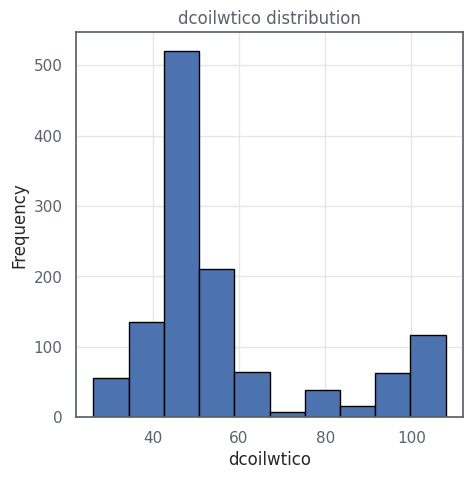

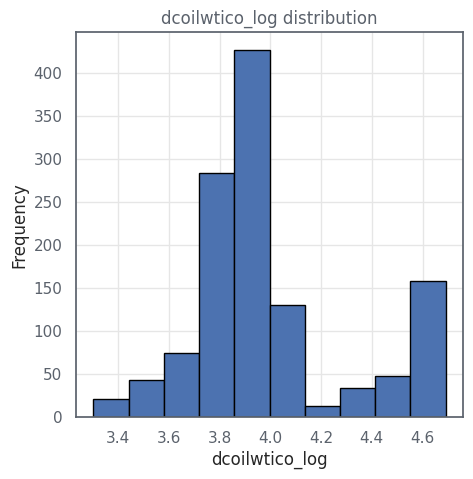

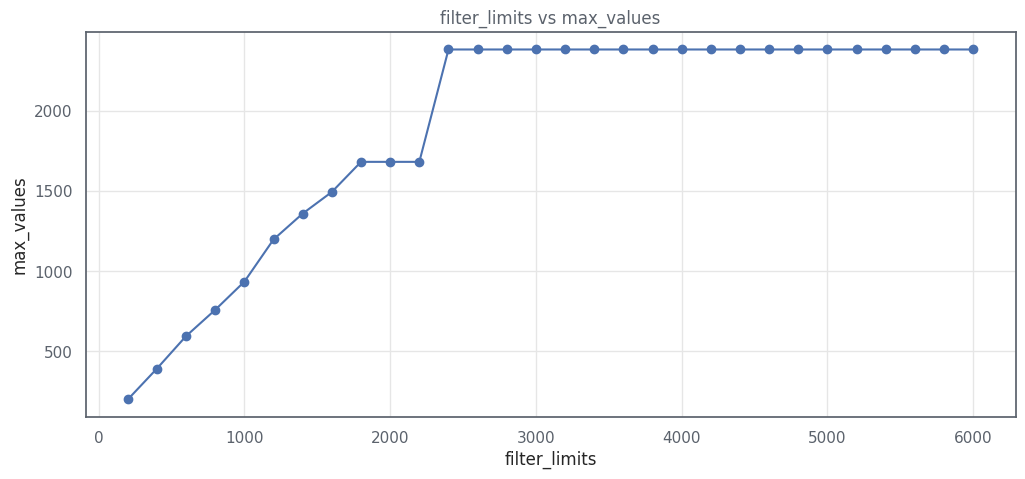



Predictor variables proportions:
january              0.075610
december             0.073171
holiday              0.073171
pre_payday_period    0.095122
payday_period        0.166667
day_1                0.143902
day_2                0.143089
day_3                0.142276
day_4                0.142276
day_5                0.143089
day_6                0.142276
suply_issues         0.223577
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     382.8
Date:                Thu, 15 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:58:35   Log-Likelihood:                -15791.
No. Observations:                1230   AIC:                         3.161e+04
Df Residuals:                    1215

,variable,coefficient,p_value,significant
0,const,583078.870000,0.000000,True
1,day_6,227634.360000,0.000000,True
2,day_5,164774.740000,0.000000,True
3,december,122651.270000,0.000000,True
4,payday_period,101970.510000,0.000000,True
5,holiday,46565.000000,0.000000,True
6,onpromotion_log,41869.880000,0.000000,True
7,pre_payday_period,-38904.690000,0.000000,True
8,dcoilwtico_log,-48718.020000,0.000000,True
9,day_2,-58655.440000,0.000000,True


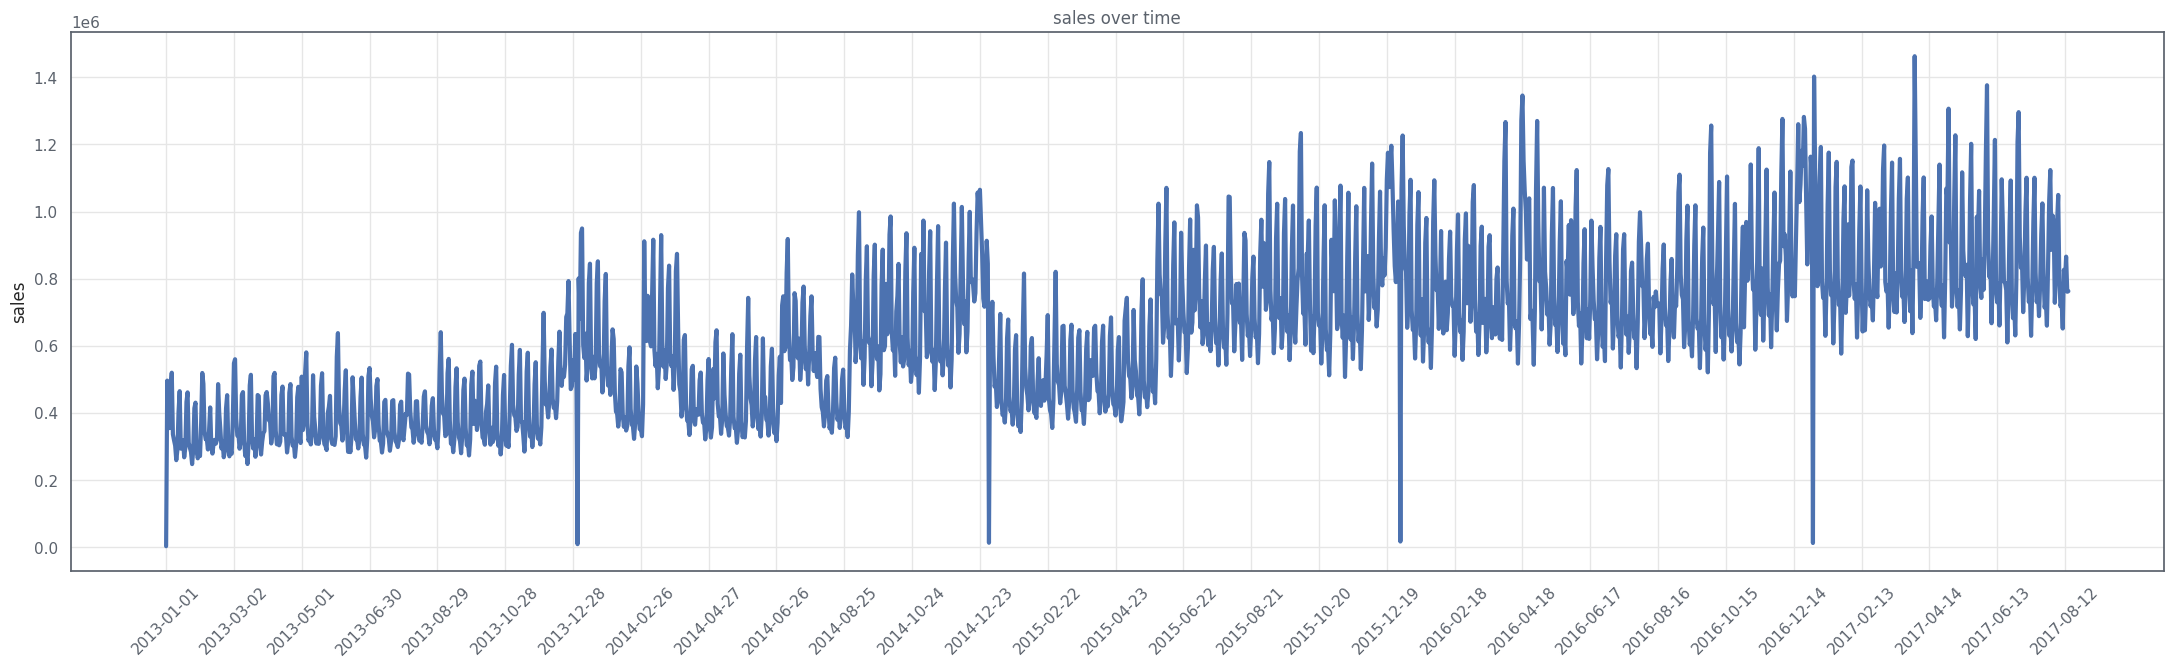

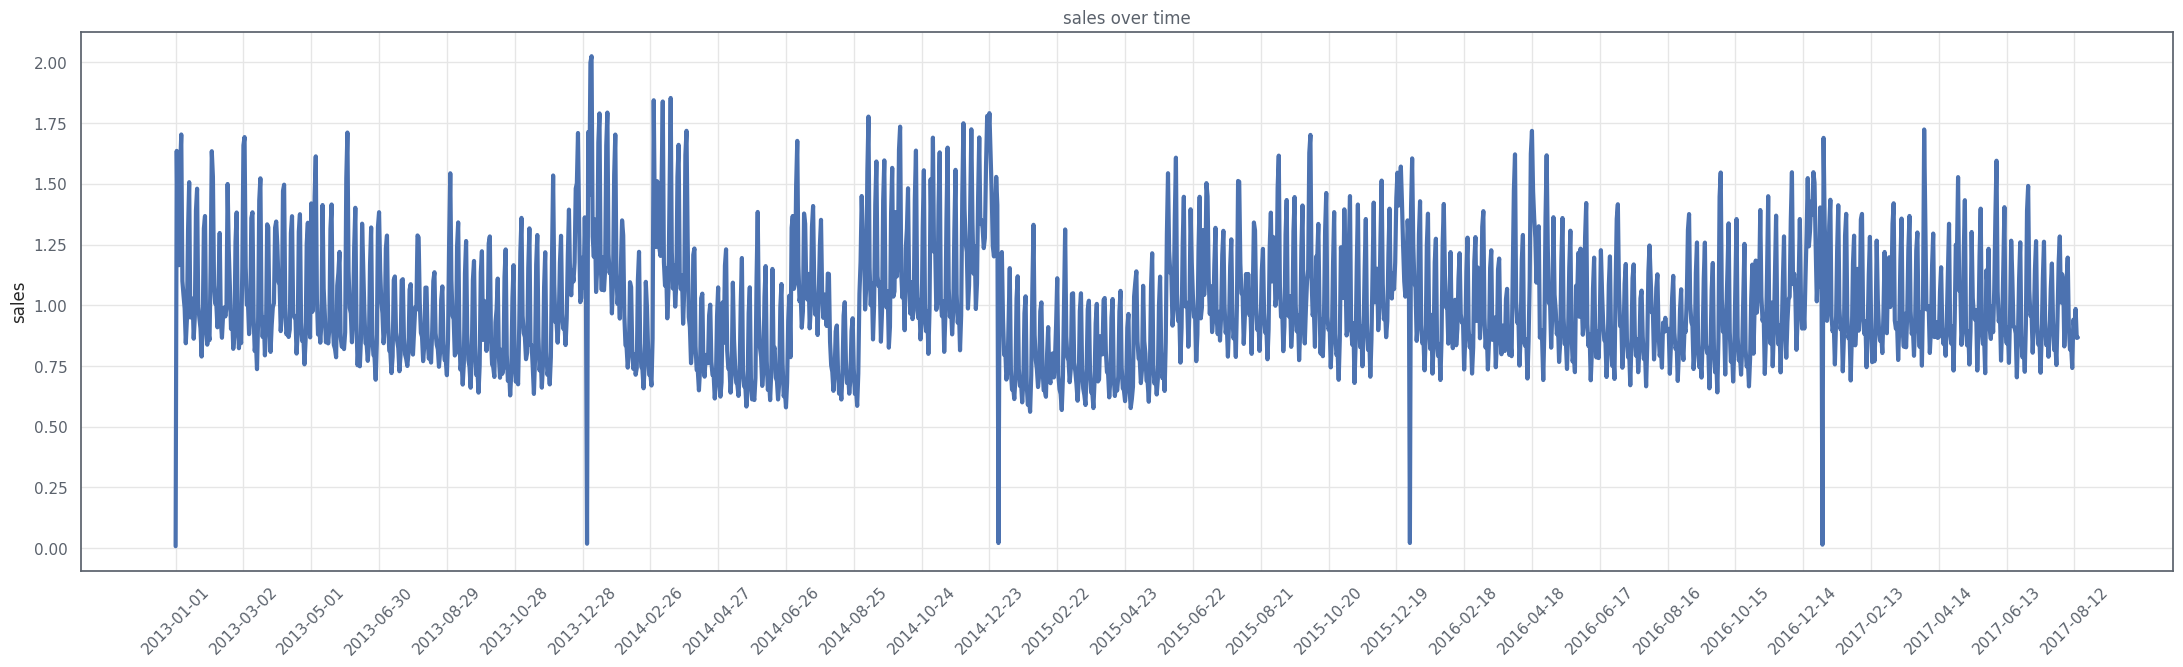


Median Difference for Extreme Event: Terremoto Manabi:


,extreme_event,control_median,treatment_median,median_diff_percent
0,Terremoto Manabi,0.869191,1.016411,16.94




Results for Extreme Event: Terremoto Manabi:


,group,statistic,pvalue,significant
0,TREATMENT,0.944020,0.153071,True
1,CONTROL,0.930541,0.000027,False


,U_statistic,pvalue,significant,adjust_pvalue,extreme_event
0,821.000000,0.000463,True,0.000463,Terremoto Manabi




Results for Extreme Event: Mundial de futbol Brasil:


,group,statistic,pvalue,significant
0,TREATMENT,0.936030,0.448417,True
1,CONTROL,0.967272,0.197870,True


,U_statistic,pvalue,significant,adjust_pvalue,extreme_event
0,286.000000,0.977885,False,0.977885,Mundial de futbol Brasil


In [60]:
summary, params, pvalues = q3(df_sales, df_oil, df_main_holidays)